In [1]:
from pathlib import Path
import os
import pickle
import random
import shutil

import glob2 as glob
import tensorflow as tf
from tensorflow.keras import callbacks, layers, models, Model
from azureml.core import Dataset, Workspace
from azureml.core.run import Run

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
workspace = Workspace.from_config()
workspace

Workspace.create(name='cgm-azureml-prod', subscription_id='9b82ecea-6780-4b85-8acf-d27d79028f07', resource_group='cgm-ml-prod')

In [4]:
dataset_name = "anon-realtime-evaluation"
dataset = Dataset.get_by_name(workspace, name=dataset_name)

In [16]:
mount_context = dataset.mount()

In [17]:
mount_context.start()  # this will mount the file streams

In [18]:
mount_context.mount_point

'/tmp/tmpgtr3f1wz'

In [19]:
! ls {mount_context.mount_point}

depthmaps  pointclouds	rgb


In [20]:
! ls {mount_context.mount_point + '/depthmaps'}

1583462505-43bak4gvfa  1585348886-e08mvfhh4i  1597675271-ers3xb9lyo
1583462533-hxipp8enl2  1585348900-lqffsr2qxc  1597675455-7m3jp0t3jb
1583462828-2dmyjcwrkp  1585348916-e0cb35whh0  1597677237-3q7ojtw1rf
1583465464-wp4uhlpyvo  1585348984-wz8v6mzvx7  1597677927-5okucz9p88
1583509169-59obayuk18  1585349364-yw4n1ln8w6  1597678269-j5qqaxi206
1583511115-ea9nmuc8qk  1585349411-0fxcwuc1jx  1597678394-jg28uhthdj
1583584872-j9z38sk7ky  1585349461-dtxe4jpcqq  1597681532-dfk5929m9m
1583654709-e2r4mbe7j2  1585349466-7foy7jt7d9  1597682611-sfbntnbbe2
1583654740-795bvonbu0  1585349494-u1bxpz36mn  1597682980-iemnyx10r7
1583655035-x5wosyip2d  1585349499-mfylbxf4f8  1597683057-19ht5kj4r3
1583683703-erlmpe14ug  1585349504-ni98n2dklp  1597683193-4tvnlfmxt9
1583740747-3retnv4b8d  1585349866-z3xaecaqio  1597683324-8qj1gwmto5
1583830760-ps06afm1ms  1585349884-rcd1sov7mb  1597684200-s7zgrrbz8s
1583830956-iih0g79996  1585349977-pi2uda4ctm  1597684413-sra0161zyi
1583830969-bkizvxcpo1  1585350040-wahzoweq9e  15

In [6]:
# ! pip install tensorflow-addons
# ! pip install tensorflow==2.3.1

In [5]:
! pip list | grep tensorflow

tensorflow                            2.3.1
tensorflow-addons                     0.11.2
tensorflow-estimator                  2.3.0
tensorflow-gpu                        2.1.0


In [7]:
import sys
print(Path(os.getcwd()).parents[2])
sys.path.append(str(Path(os.getcwd()).parents[2]))  # src/ dir

from common.model_utils.utils import get_dataset_path, download_dataset

/mnt/batch/tasks/shared/LS_root/mounts/clusters/mhinsche-ds16/code/Users/mhinsche/cgm-ml/src


In [9]:
# Downlaod dataset
# DATA_DIR_ONLINE_RUN = Path("/tmp/data/")
# dataset_path = get_dataset_path(DATA_DIR_ONLINE_RUN, dataset_name)
# download_dataset(workspace, dataset_name, dataset_path)

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

from data_utils.data_visualisation.visualization_utils import (IMAGE_TARGET_HEIGHT, 
    IMAGE_TARGET_WIDTH, REPO_DIR, show_pickle, path_to_ndarray, choose_a_pickle_file, get_datetime, py_load_pickle)

In [15]:
qrcode_path_ = Path("/tmp/data/anon-realtime-evaluation/depthmaps/1585015418-c5fsm1xtkt")
qrcode_path = str(qrcode_path_ / "100/")  # contains .p files
path_with_wildcard = os.path.join(qrcode_path, "*.p")
list_of_pickle_file_paths = sorted(glob.glob(path_with_wildcard))

In [16]:
list_of_pickle_file_paths

['/tmp/data/anon-realtime-evaluation/depthmaps/1585015418-c5fsm1xtkt/100/pc_1585015418-c5fsm1xtkt_1591875489591_100_000.p',
 '/tmp/data/anon-realtime-evaluation/depthmaps/1585015418-c5fsm1xtkt/100/pc_1585015418-c5fsm1xtkt_1591875489591_100_001.p',
 '/tmp/data/anon-realtime-evaluation/depthmaps/1585015418-c5fsm1xtkt/100/pc_1585015418-c5fsm1xtkt_1591875489591_100_002.p',
 '/tmp/data/anon-realtime-evaluation/depthmaps/1585015418-c5fsm1xtkt/100/pc_1585015418-c5fsm1xtkt_1591875489591_100_003.p',
 '/tmp/data/anon-realtime-evaluation/depthmaps/1585015418-c5fsm1xtkt/100/pc_1585015418-c5fsm1xtkt_1591875489591_100_004.p',
 '/tmp/data/anon-realtime-evaluation/depthmaps/1585015418-c5fsm1xtkt/100/pc_1585015418-c5fsm1xtkt_1591875489591_100_005.p',
 '/tmp/data/anon-realtime-evaluation/depthmaps/1585015418-c5fsm1xtkt/100/pc_1585015418-c5fsm1xtkt_1591875489591_100_006.p']

In [26]:
def show_pickle(pickle_file_path):
    depthmap, _targets = py_load_pickle(pickle_file_path)
    # depthmap = tf.reshape(depthmap, (IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH))
    plt.imshow(depthmap.numpy(), cmap='gray', vmin=0, vmax=1)
    print(f"height: {_targets[0]:.2f} cm")

5 /tmp/data/anon-realtime-evaluation/depthmaps/1585015418-c5fsm1xtkt/100/pc_1585015418-c5fsm1xtkt_1591875489591_100_005.p
height: 104.90 cm


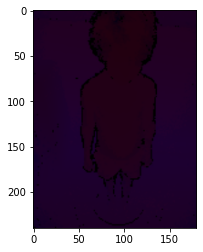

In [27]:
# Naive step visualization
i = 5

print(i, list_of_pickle_file_paths[i])
show_pickle(list_of_pickle_file_paths[i])
i += 1

In [28]:
pickle_file_path = list_of_pickle_file_paths[i]
depthmap, _targets = py_load_pickle(pickle_file_path)

In [29]:
depthmap.shape

TensorShape([240, 180, 3])

In [30]:
_targets

array([104.9], dtype=float32)